# 匯入套件、讀檔

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_excel("for_model_考慮變動量.xlsx")

In [3]:
data.fillna(0, inplace=True)

刪除碳排為零的資料 = data[(data['總碳排量'] == 0)].index
data = data.drop(刪除碳排為零的資料, inplace=False)

In [4]:
#修正名稱中空白、換行的格式
data.columns = data.columns.str.replace(" ", "")
data.columns = data.columns.str.replace("\n", "")

#針對產業別中的文字空白與換行問題
data["產業別"] = data["產業別"].replace(r'\n', '', regex=True)
data["產業別"] = data["產業別"].replace(r' ', '', regex=True)

In [5]:
產業別 = data["產業別"]

In [6]:
data.columns

Index(['Unnamed:0', '公司代號', '公司名稱', '產業別', '年', '總碳排量', '生產量', '存貨',
       '不動產廠房及設備', '商譽及無形資產合計', '預付投資款', '應付帳款及票據', '普通股股本', '資本公積合計', '營業成本',
       '營業費用', '研究發展費', '處分不動產廠房設備（含預付）－CFI', '折舊－CFO', '攤提－CFO',
       '購置不動產廠房設備（含預付）－CFI', '員工人數', 'wpiindex', 'deflator'],
      dtype='object')

# 將特徵值分成三個不同的資料集

1. 原有資料集：`X_old `
    (不含產業別虛擬變數，未加入特徵工程值：生產量)
2. 原有資料集 + 生產量：`X_with_productivity`
3. 原有資料集 + 生產量 + 產業別虛擬變數 ：`data_with_productivity_and_onehot`


> $ 生產量_t = {存貨_t - 存貨_{t-1}} + 營業成本_t + 營業費用_t $

***

In [7]:
X_old = data[['存貨',
       '不動產廠房及設備', '商譽及無形資產合計', '預付投資款', '應付帳款及票據', '普通股股本', '資本公積合計', '營業成本',
       '營業費用', '研究發展費', '處分不動產廠房設備（含預付）－CFI', '折舊－CFO', '攤提－CFO',
       '購置不動產廠房設備（含預付）－CFI', '員工人數']]

X_with_productivity = data[['生產量', '存貨',
       '不動產廠房及設備', '商譽及無形資產合計', '預付投資款', '應付帳款及票據', '普通股股本', '資本公積合計', '營業成本',
       '營業費用', '研究發展費', '處分不動產廠房設備（含預付）－CFI', '折舊－CFO', '攤提－CFO',
       '購置不動產廠房設備（含預付）－CFI', '員工人數']]

In [8]:
data_with_productivity_and_industry = data[['產業別', '生產量', '存貨',
       '不動產廠房及設備', '商譽及無形資產合計', '預付投資款', '應付帳款及票據', '普通股股本', '資本公積合計', '營業成本',
       '營業費用', '研究發展費', '處分不動產廠房設備（含預付）－CFI', '折舊－CFO', '攤提－CFO',
       '購置不動產廠房設備（含預付）－CFI', '員工人數']]

X_with_productivity_and_OnehotIndustry = pd.get_dummies(data_with_productivity_and_industry, columns = ["產業別"])

In [9]:
y = data["總碳排量"]

# 資料分割-訓練集、測試集

In [10]:
# 載入 train_test_split()方法
from sklearn.model_selection import train_test_split

X_old_train, X_old_test, y_train, y_test = train_test_split(X_old, y, test_size = 0.2, random_state = 0)

#X_with_p_train, X_with_p_test, y_train, y_test = train_test_split(X_with_productivity, y, test_size = 0.2, random_state = 0)

X_with_p_and_onehot_train, X_with_p_and_onehot_test, y_train, y_test = train_test_split(X_with_productivity_and_OnehotIndustry, y, test_size = 0.2, random_state = 0)

# 建立XGBoost

>這裡先使用同時有生產量和產業別變數的資料集

In [11]:
import xgboost as xgb

# 建立xgbrModel模型
xgb_regModel = xgb.XGBRegressor()

# 使用訓練資料訓練模型
xgb_regModel.fit(X_with_p_and_onehot_train, y_train)

# 使用訓練資料預測
predicted = xgb_regModel.predict(X_with_p_and_onehot_train)

>觀察training accuracy，也就是training data set's $R^2$以及MSE

In [12]:
from sklearn import metrics

In [13]:
print("Traing R^2: ", xgb_regModel.score(X_with_p_and_onehot_train, y_train))
mse = metrics.mean_squared_error(y_train, predicted)
print('MSE score: ', mse)

Traing R^2:  0.9999999801533095
MSE score:  374075.62486639764


In [14]:
#看測試集R^2

print("Testing R^2: ", xgb_regModel.score(X_with_p_and_onehot_test, y_test))

Testing R^2:  0.9910278514769612


In [15]:
#用所有X去估計Y
full_fitted = xgb_regModel.predict(X_with_productivity_and_OnehotIndustry)
X_with_productivity_and_OnehotIndustry["full_fitted"] = full_fitted

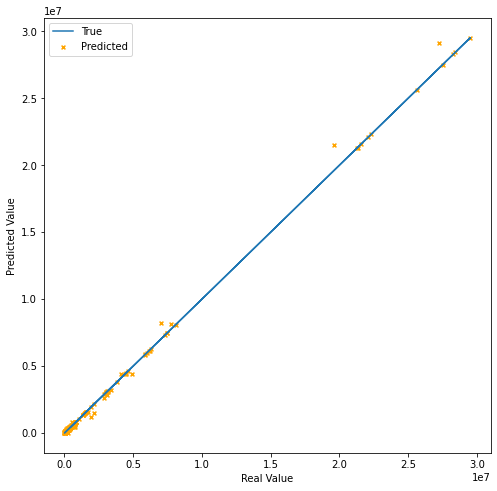

Traing R^2:  0.9999999801533095
MSE score:  374075.62486639764
Testing R^2:  0.9910278514769612


In [16]:
# plot
plt.figure(figsize=(8,8))
plt.plot(y, y, label='True')
plt.scatter(y, full_fitted,marker='x', color="orange",s = 15, label='Predicted')
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()

print("Traing R^2: ", xgb_regModel.score(X_with_p_and_onehot_train, y_train))
mse = metrics.mean_squared_error(y_train, predicted)
print('MSE score: ', mse)

#看測試集R^2

print("Testing R^2: ", xgb_regModel.score(X_with_p_and_onehot_test, y_test))


# 嘗試減少輸入的特徵值數量



## 列出XGBoost認為的重要特徵

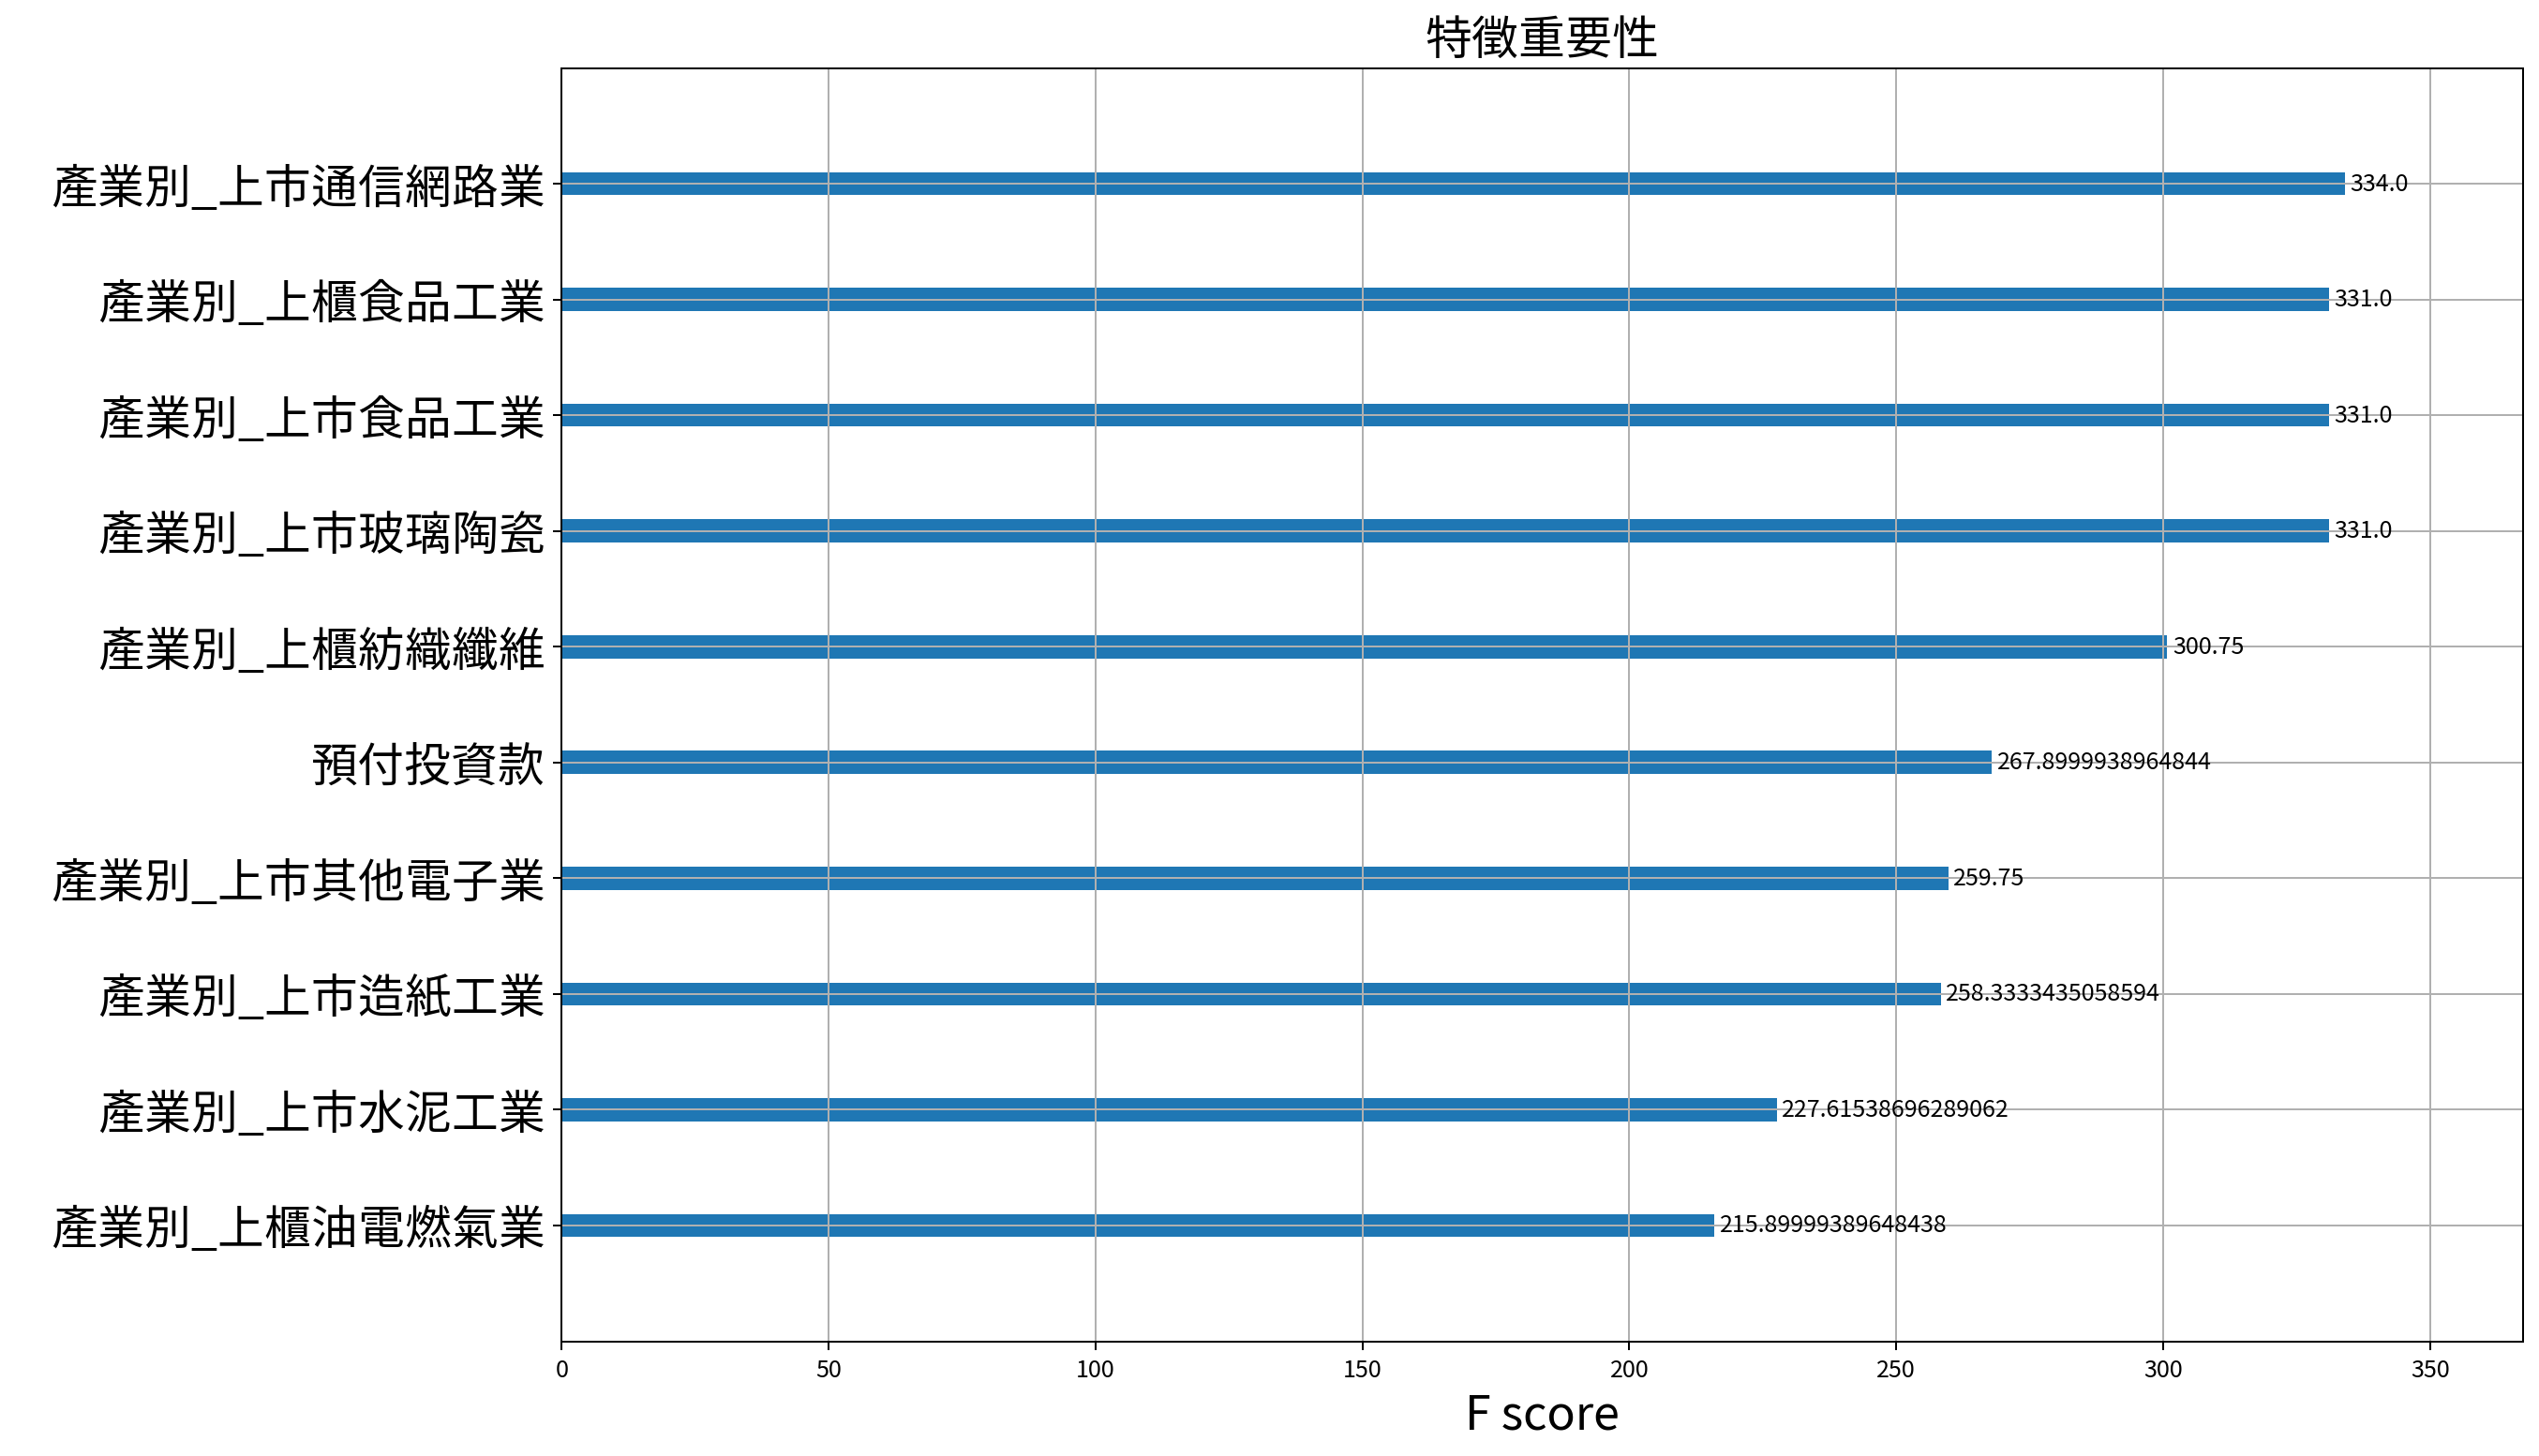

In [17]:
from xgboost import plot_importance
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
fig, ax = plt.subplots(figsize=(15, 10), dpi = 180)
plt.yticks(fontsize = 20)
xgb.plot_importance(xgb_regModel, ax=ax, importance_type='cover', max_num_features=10)
plt.ylabel(" ")
plt.xlabel("F score", fontsize = 20)
plt.title("特徵重要性", fontsize = 20)
plt.show()

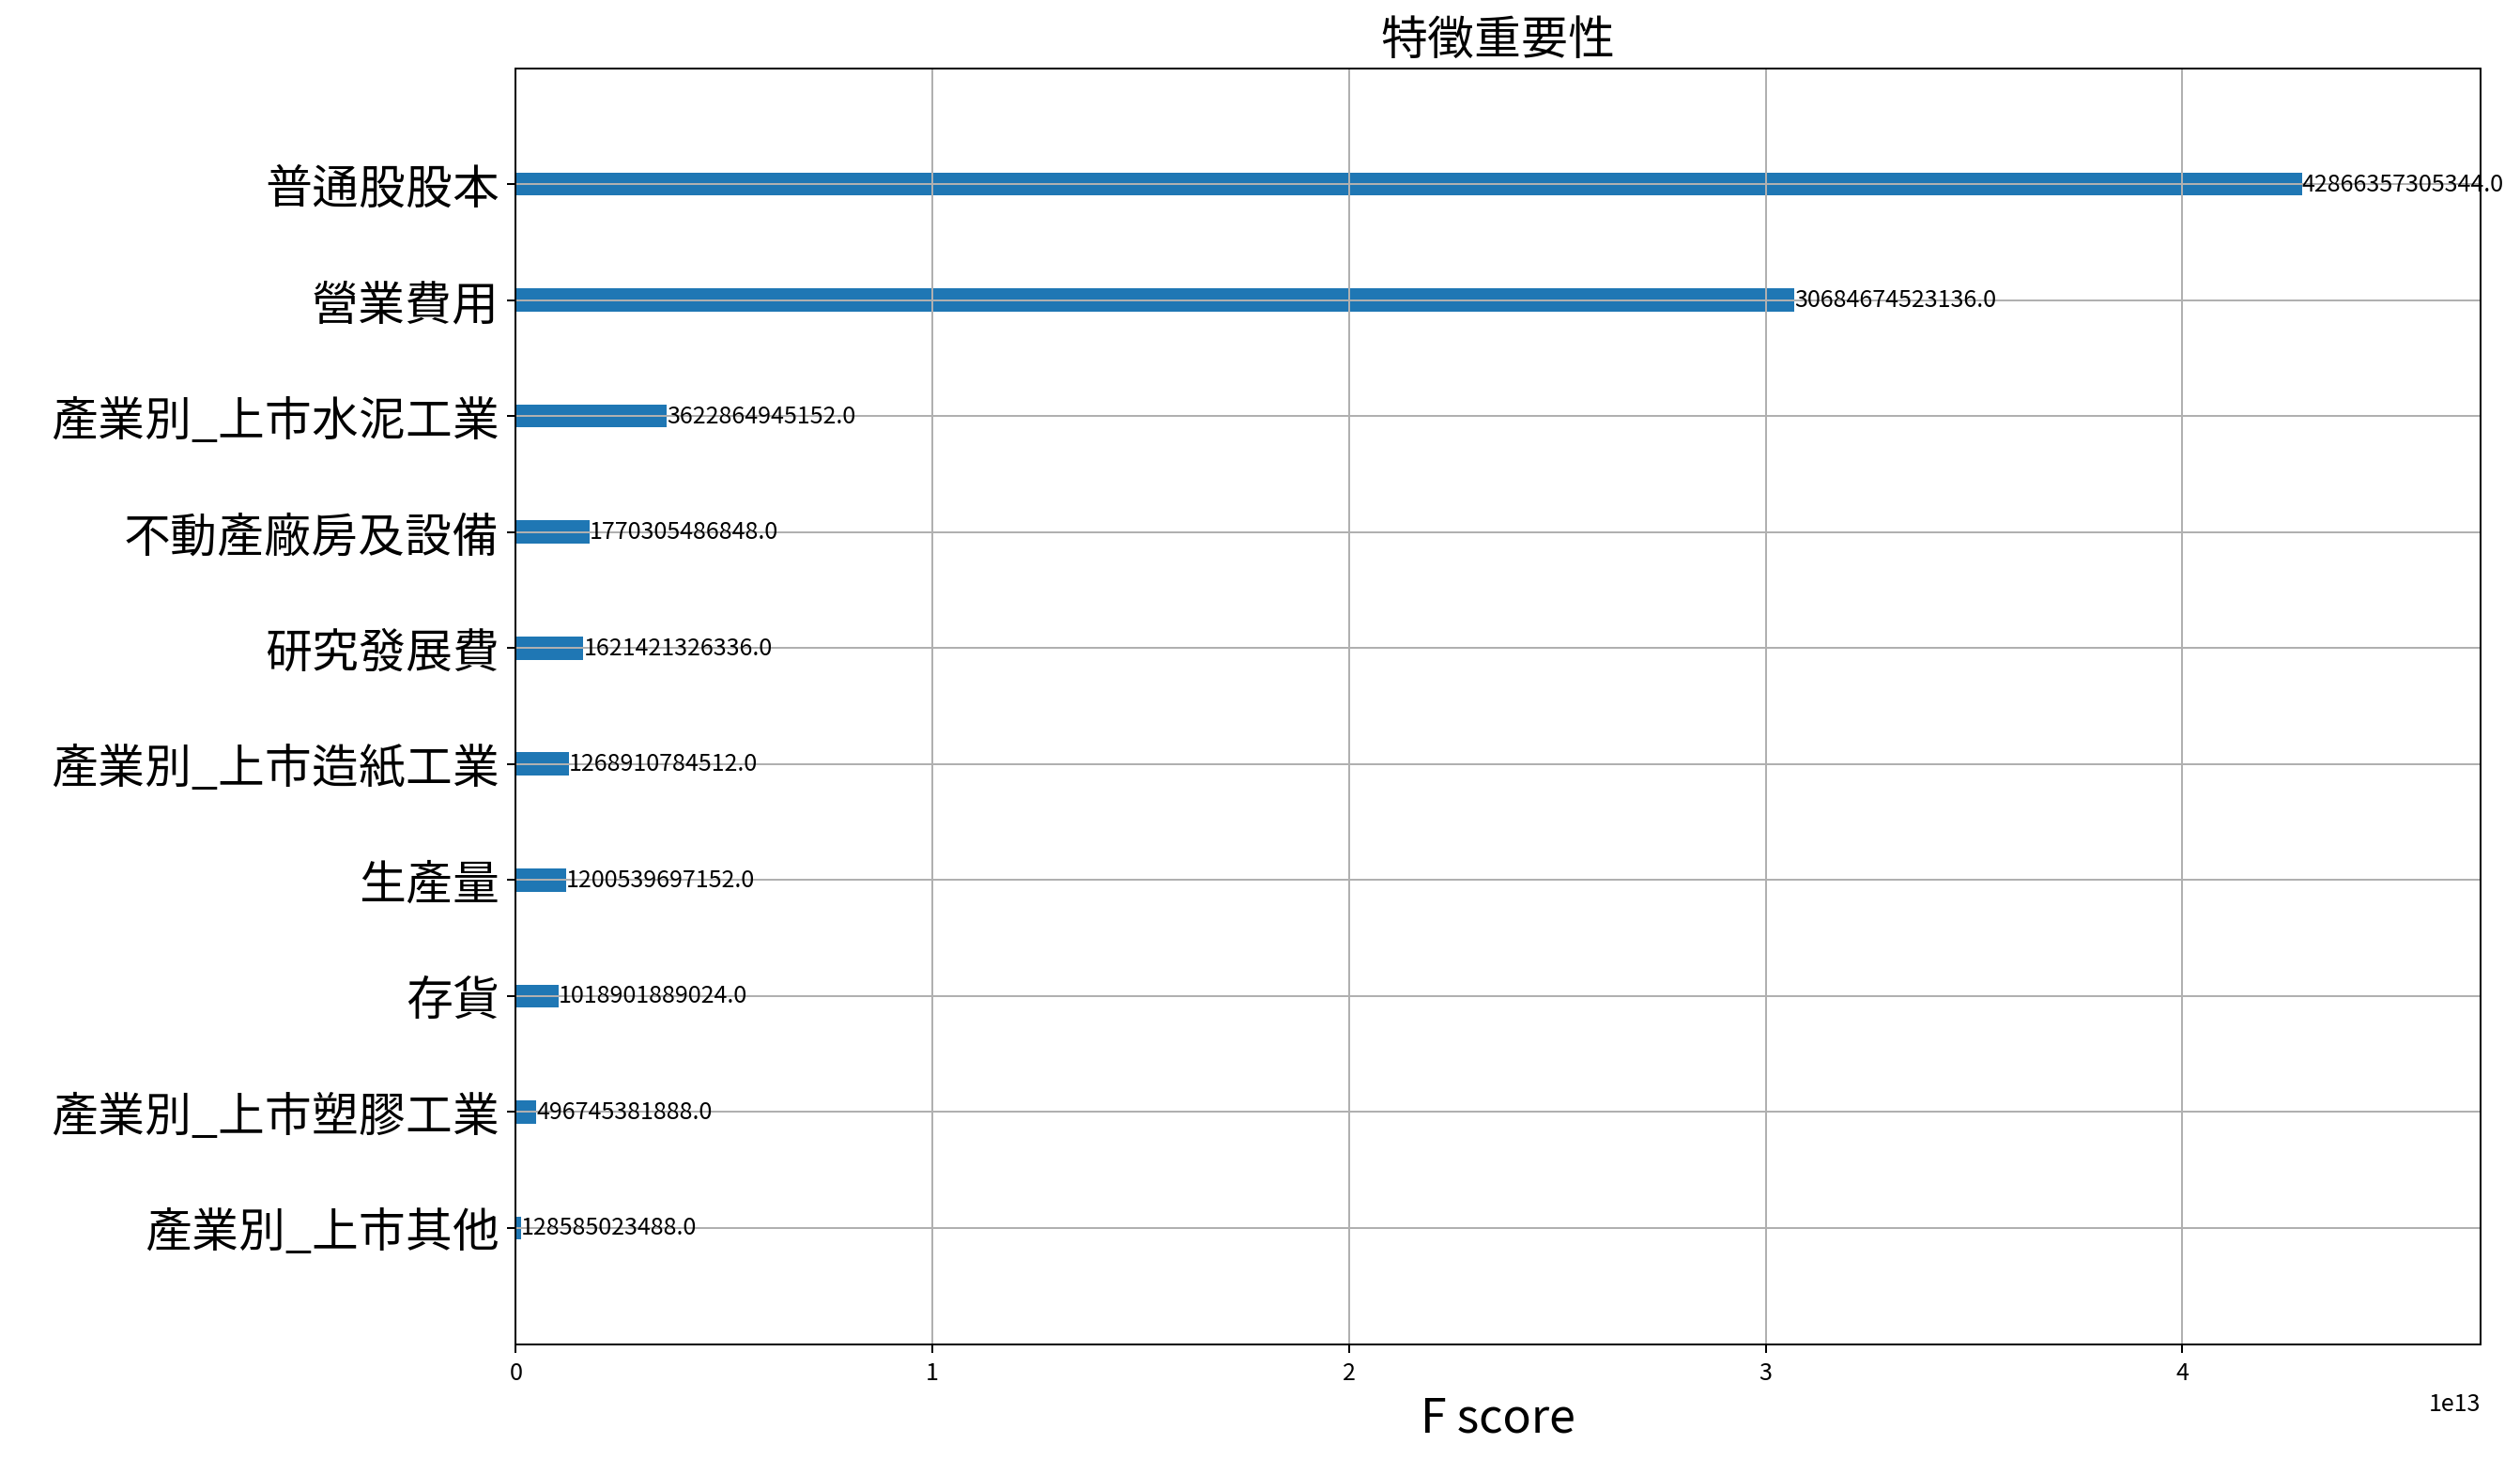

In [18]:
from xgboost import plot_importance
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
fig, ax = plt.subplots(figsize=(15, 10), dpi = 180)
plt.yticks(fontsize = 20)
xgb.plot_importance(xgb_regModel, ax=ax, importance_type='gain', max_num_features=10)
plt.ylabel(" ")
plt.xlabel("F score", fontsize = 20)
plt.title("特徵重要性", fontsize = 20)
plt.show()

In [19]:
#將重要變數取出
feature_important = xgb_regModel.get_booster().get_score(importance_type='weight')

#取出重要變數名稱
keys = list(feature_important.keys())

#取出重要變數的F score
values = list(feature_important.values())

In [20]:
df_importance_feature = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
df_importance_feature.head(10)

,score
生產量,470.0
存貨,239.0
不動產廠房及設備,182.0
應付帳款及票據,161.0
普通股股本,155.0
商譽及無形資產合計,135.0
營業費用,129.0
攤提－CFO,123.0
處分不動產廠房設備（含預付）－CFI,120.0
購置不動產廠房設備（含預付）－CFI,117.0


In [21]:
df_importance_feature[:][6:7]  + df_importance_feature[:][:4] 

,score
不動產廠房及設備,NaN
存貨,NaN
應付帳款及票據,NaN
營業費用,NaN
生產量,NaN


In [22]:
#df_importance_feature.index[:7].tolist()
df_importance_feature.index[:5].tolist()

['生產量', '存貨', '不動產廠房及設備', '應付帳款及票據', '普通股股本']

In [23]:
#top_tier_list = df_importance_feature.index[:7].tolist()
top_tier_list = df_importance_feature.index[:5].tolist()

#去除產業別的欄位名稱


for item in top_tier_list:
    if item[-1:] == '業':
        top_tier_list.remove(item)

#利用底線的出現刪去產業別dummy
top_tier_list = [item for item in top_tier_list if "_" not in item]  

top_tier_list

>嘗試只輸入這五個變數，其他數字都用平均數，還是產業平均數?

# 測試如果除了以上五個變數以外皆為均值的模型結果
>生成資料：除了上述五個以外都以產業均數的資料集

In [24]:
#先去除上述五個變數，用column數確認
features_without_top5 = X_with_productivity_and_OnehotIndustry.drop(columns = top_tier_list).columns
len(features_without_top5)

36

In [25]:
#這裡的變數皆未變成產業平均
X_mean_with_top5 = X_with_productivity_and_OnehotIndustry[features_without_top5]

In [26]:
#先加入"產業別，"方便下方groupby
X_mean_with_top5["產業別"] = 產業別

#將所有變數改為該產業平均
X_mean_with_top5[features_without_top5] = X_mean_with_top5.groupby('產業別')[features_without_top5].transform('mean')

#去除產業別，因為非數值
X_mean_with_top5 = X_mean_with_top5.drop(columns = "產業別")


In [27]:
X_mean_with_top5[top_tier_list] = data[top_tier_list]

In [28]:
X_mean_with_top5_train, X_mean_with_top5_test, y_train, y_test = train_test_split(X_mean_with_top5, y, test_size = 0.2, random_state = 0)

In [29]:
# 建立xgbrModel模型
xgb_reg_mean_with_top5_Model = xgb.XGBRegressor()

# 使用訓練資料訓練模型
xgb_reg_mean_with_top5_Model.fit(X_mean_with_top5_train, y_train)

# 使用訓練資料預測
predicted = xgb_reg_mean_with_top5_Model.predict(X_mean_with_top5_train)

print("Traing R^2: ", xgb_reg_mean_with_top5_Model.score(X_mean_with_top5_train, y_train))
mse = metrics.mean_squared_error(y_train, predicted)
print('MSE score: ', mse)

#看測試集R^2

print("Testing R^2: ", xgb_reg_mean_with_top5_Model.score(X_mean_with_top5_test, y_test))


Traing R^2:  0.9999999501356681
MSE score:  939855.9984298918
Testing R^2:  0.9869252255530462


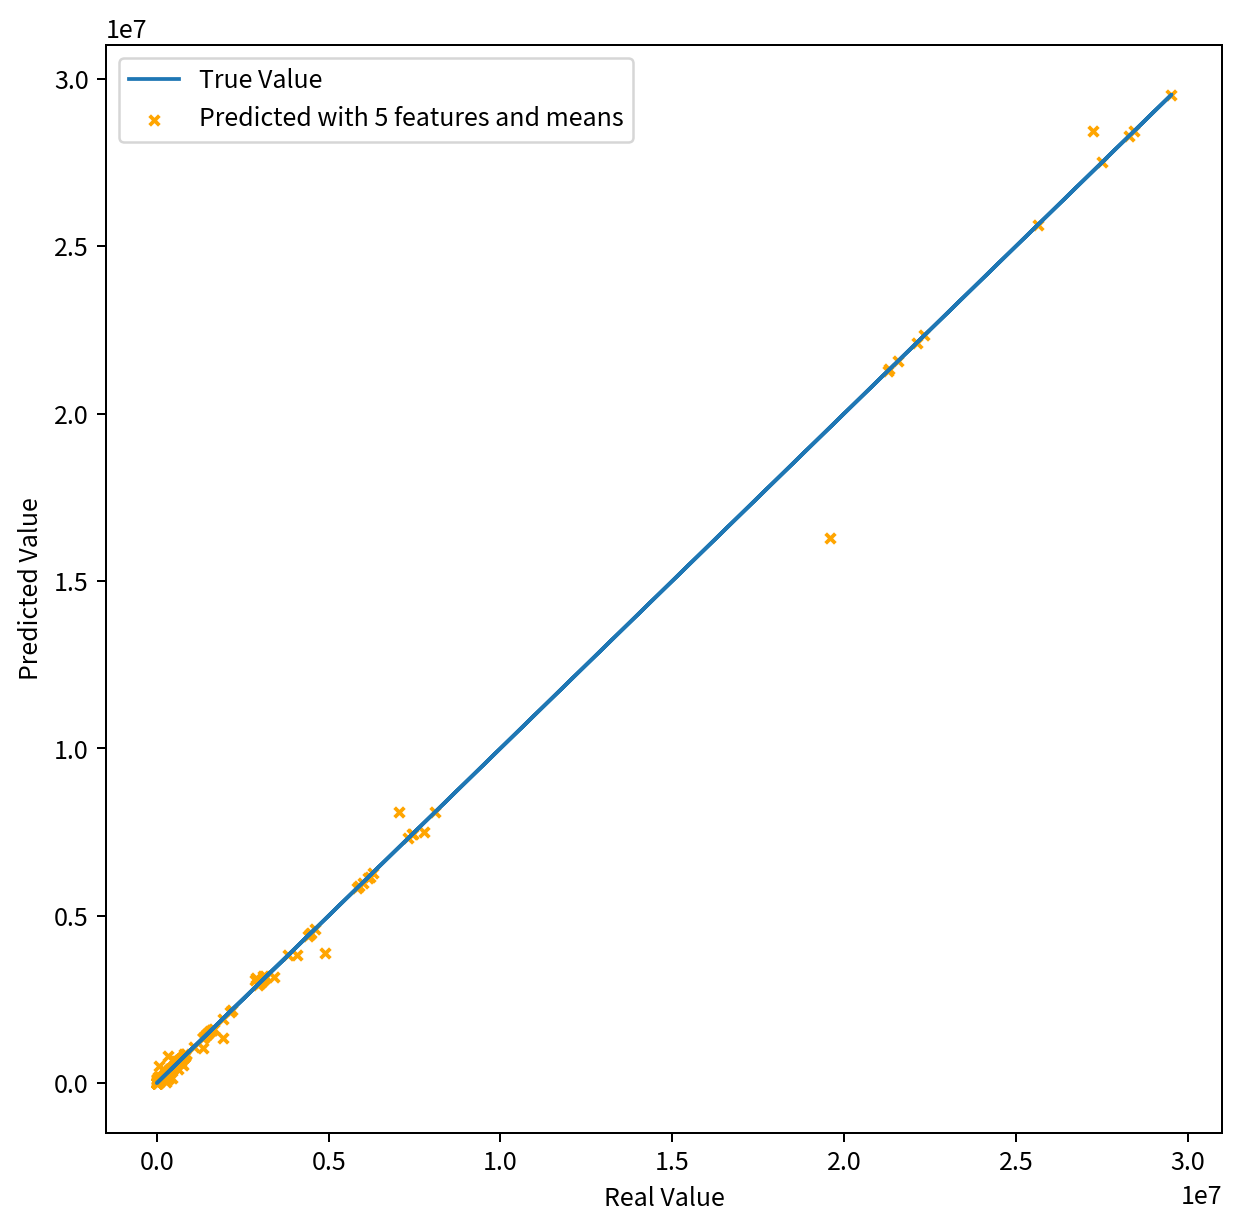

Traing R^2:  0.9999999501356681
MSE score:  939855.9984298918
Testing R^2:  0.9869252255530462


In [30]:
full_fitted = xgb_reg_mean_with_top5_Model.predict(X_mean_with_top5)

# plot
plt.figure(figsize=(8,8), dpi = 180)
plt.plot(y, y, label='True Value')
plt.scatter(y, full_fitted,marker='x', color="orange",s = 15, label='Predicted with 5 features and means')
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()

print("Traing R^2: ", xgb_reg_mean_with_top5_Model.score(X_mean_with_top5_train, y_train))
mse = metrics.mean_squared_error(y_train, predicted)
print('MSE score: ', mse)

#看測試集R^2

print("Testing R^2: ", xgb_reg_mean_with_top5_Model.score(X_mean_with_top5_test, y_test))


# 考慮只輸入五個變數

In [67]:
X_5_features = X_with_productivity_and_OnehotIndustry[top_tier_list]

In [68]:
X_5_features_train, X_5_features_test, y_train, y_test = train_test_split(X_5_features, y, test_size = 0.2, random_state = 10)

In [69]:
# 建立xgbrModel模型
xgb_reg_5_features_Model = xgb.XGBRegressor(max_depth = 18)

# 使用訓練資料訓練模型
xgb_reg_5_features_Model.fit(X_5_features_train, y_train)

# 使用訓練資料預測
predicted = xgb_reg_5_features_Model.predict(X_5_features_train)

print("Traing R^2: ", xgb_reg_5_features_Model.score(X_5_features_train, y_train))
mse = metrics.mean_squared_error(y_train, predicted)
print('MSE score: ', mse)

#看測試集R^2

print("Testing R^2: ", xgb_reg_5_features_Model.score(X_5_features_test, y_test))


Traing R^2:  0.9999999999999715
MSE score:  0.5347047635984278
Testing R^2:  0.9528109432402156


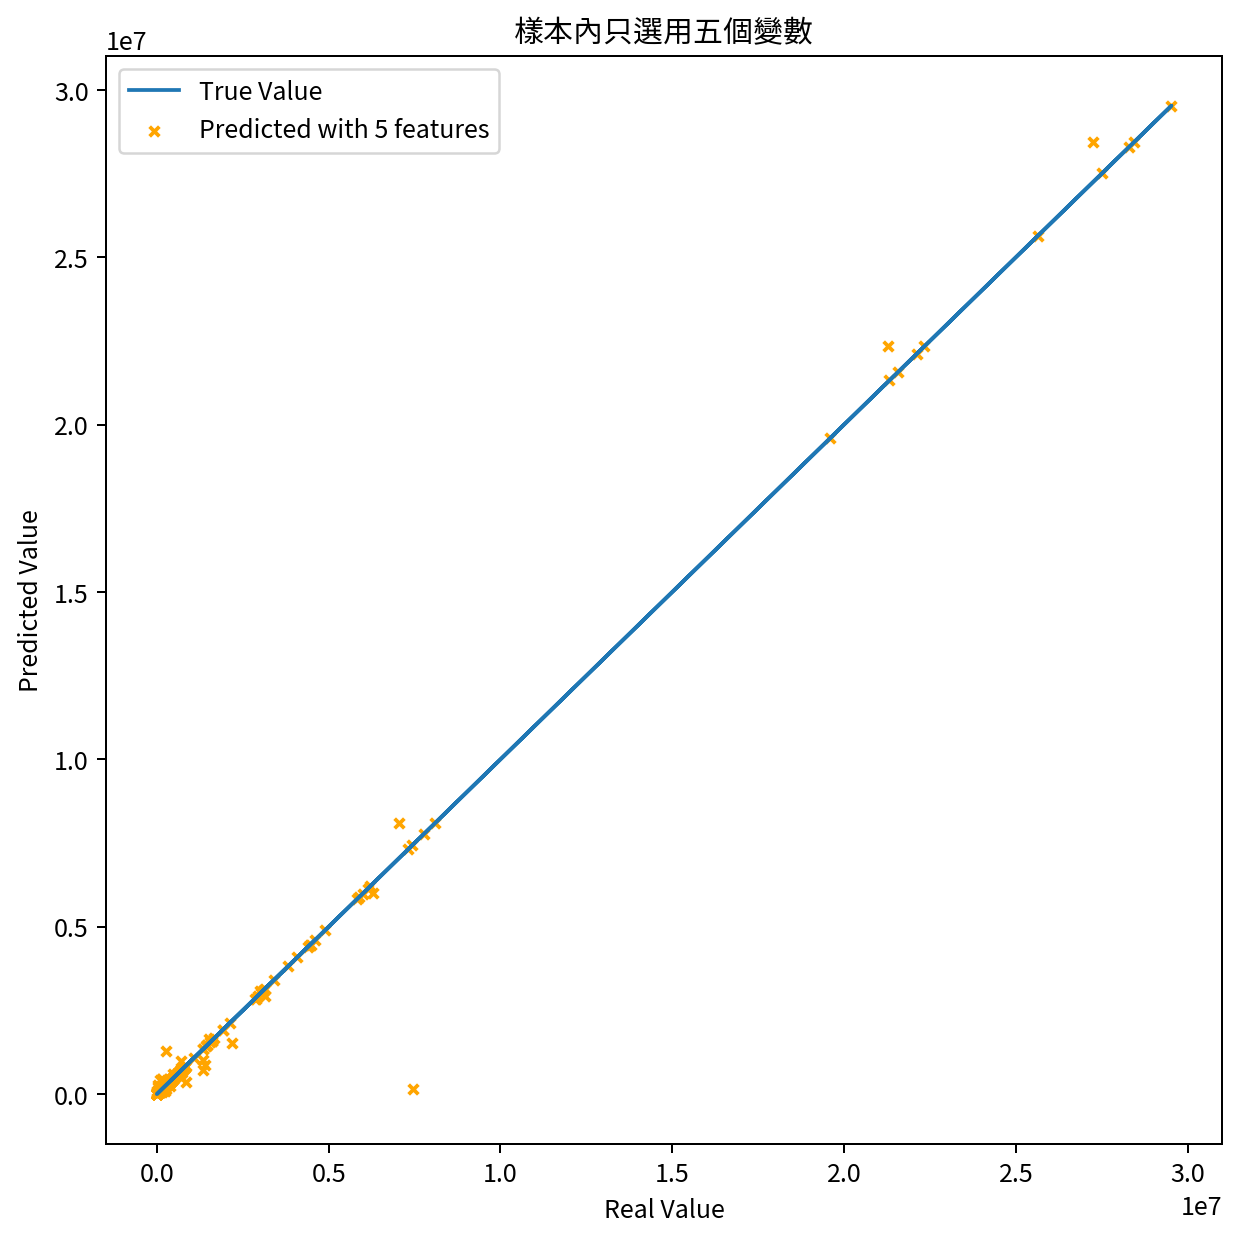

Traing R^2:  0.9999999999999715
MSE score:  0.5347047635984278
Testing R^2:  0.9528109432402156


In [70]:
full_fitted = xgb_reg_5_features_Model.predict(X_5_features)

# plot
plt.figure(figsize=(8,8), dpi = 180)
plt.plot(y, y, label='True Value')
plt.scatter(y, full_fitted,marker='x', color="orange",s = 15, label='Predicted with 5 features')
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.title("樣本內只選用五個變數")
plt.legend()
plt.show()
print("Traing R^2: ", xgb_reg_5_features_Model.score(X_5_features_train, y_train))
mse = metrics.mean_squared_error(y_train, predicted)
print('MSE score: ', mse)

#看測試集R^2

print("Testing R^2: ", xgb_reg_5_features_Model.score(X_5_features_test, y_test))

# Out-sample測試
>樣本外資料選用碳排放資料不連續，但財報資料完整的上市上櫃公司

## 資料處理

>財報平減

In [71]:
out_sample = pd.read_excel("out_sample.xlsx")
out_sample = out_sample.dropna()

In [72]:
#匯入躉售物價指數，以此指數消除不同時間點下的物價不一致性。
wpi = pd.read_csv("wpi.csv")
#生成變數，以利下方以"年"這個單位合併dataframe
wpi["date"] = pd.to_datetime(wpi["date"])
wpi["年"] = wpi["date"].dt.year

#將wpi這個df合併至TEJ這個df
out_sample = pd.merge(out_sample, wpi, how = "left", on = "年")# , suffixes=(False))
#創造平減指數
out_sample["deflator"] = out_sample["wpi index"]/100

#平減計算
out_sample.iloc[:, 5:-3] = out_sample.iloc[:, 5:-3].div(out_sample["deflator"], axis = "index")


In [73]:
X_OutSample = out_sample.iloc[:, 5:-3]
#X_OutSample["產業別"] = out_sample["產業別"]


In [74]:
#取出只有五個變數
X_OutSample_5_features = X_OutSample[top_tier_list]

In [75]:
y_OutSample = out_sample["總碳排量"]

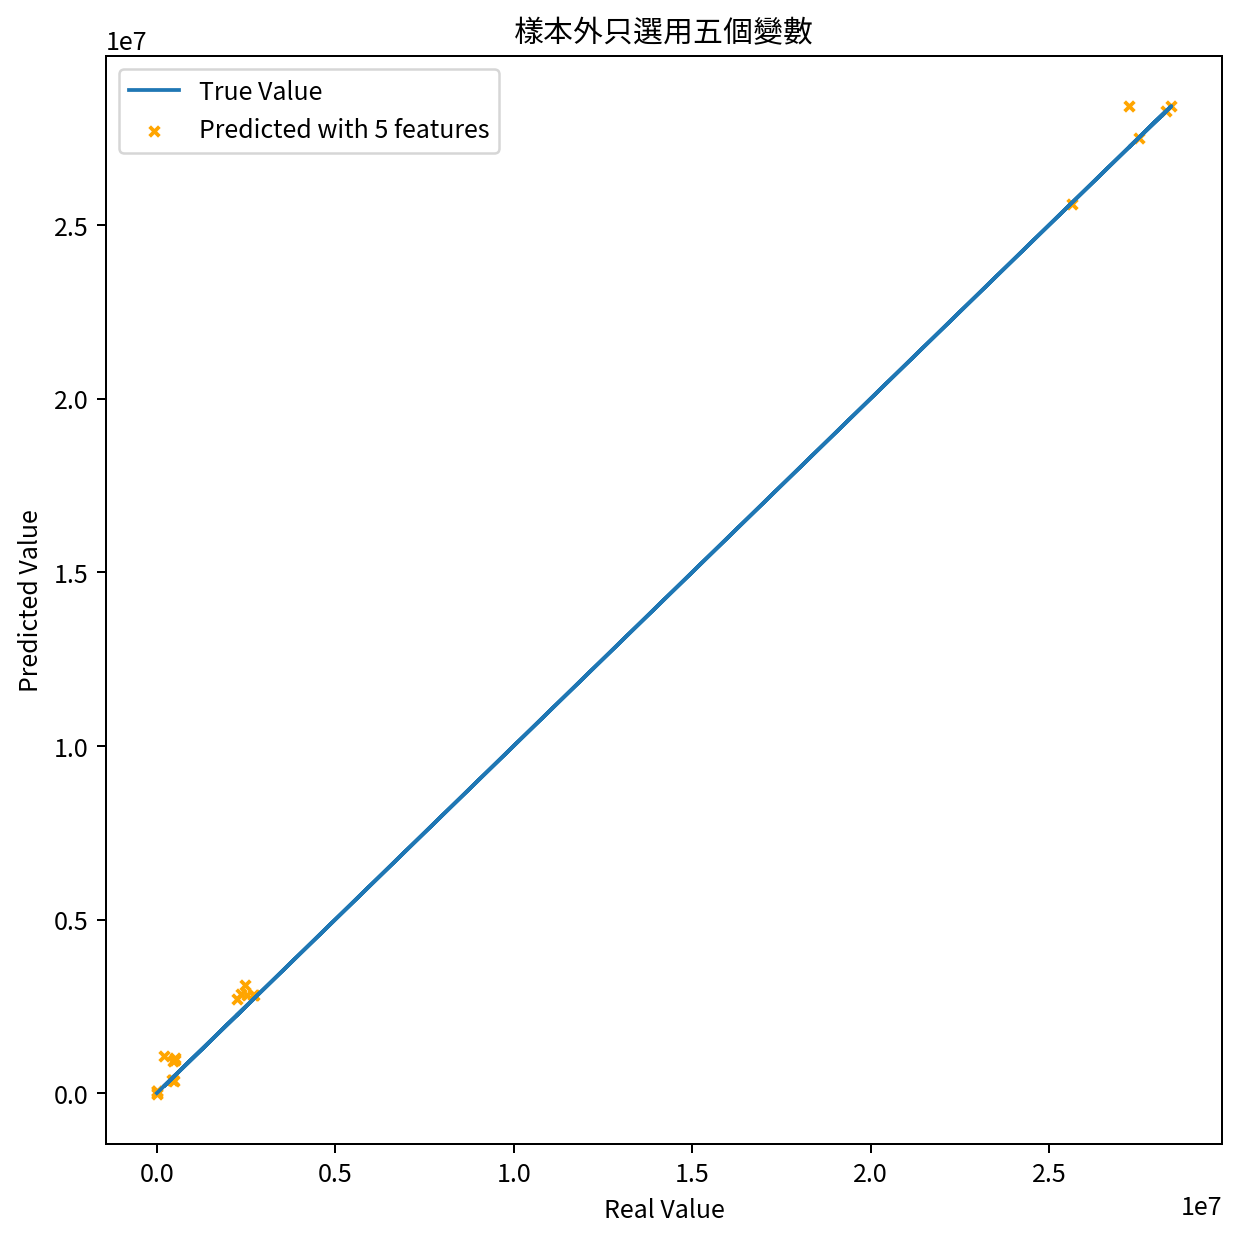

Out Sample 5 features R^2:  0.9985370417787325


In [76]:
#out Sample with only 5 figures
full_fitted_5_features = xgb_reg_5_features_Model.predict(X_OutSample_5_features)

# plot
plt.figure(figsize=(8,8), dpi = 180)
plt.plot(y_OutSample, y_OutSample, label='True Value')
plt.scatter(y_OutSample, full_fitted_5_features,marker='x', color="orange",s = 15, label='Predicted with 5 features')
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.title("樣本外只選用五個變數")
plt.legend()
plt.show()

print("Out Sample 5 features R^2: ", xgb_reg_5_features_Model.score(X_OutSample_5_features, y_OutSample))


# 視覺化實際值$\pm 5\%$與估計值的關係

ref：https://aegis4048.github.io/comprehensive_confidence_intervals_for_python_developers#conf_int_of_other

In [77]:
# plotting

def styling(ax, xticks, xticklables):
    ax.legend(fontsize=18, loc='upper right', framealpha=1, frameon=True)
    ax.set_facecolor('#eeeeee')
    ax.grid(True, linestyle='--', color='#acacac')
    ax.tick_params(color='grey')
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(label) for label in xticklables], rotation = 45, fontsize=18)
    _ = [spine.set_edgecolor('grey') for spine in ax.spines.values()]



In [78]:
import statistics

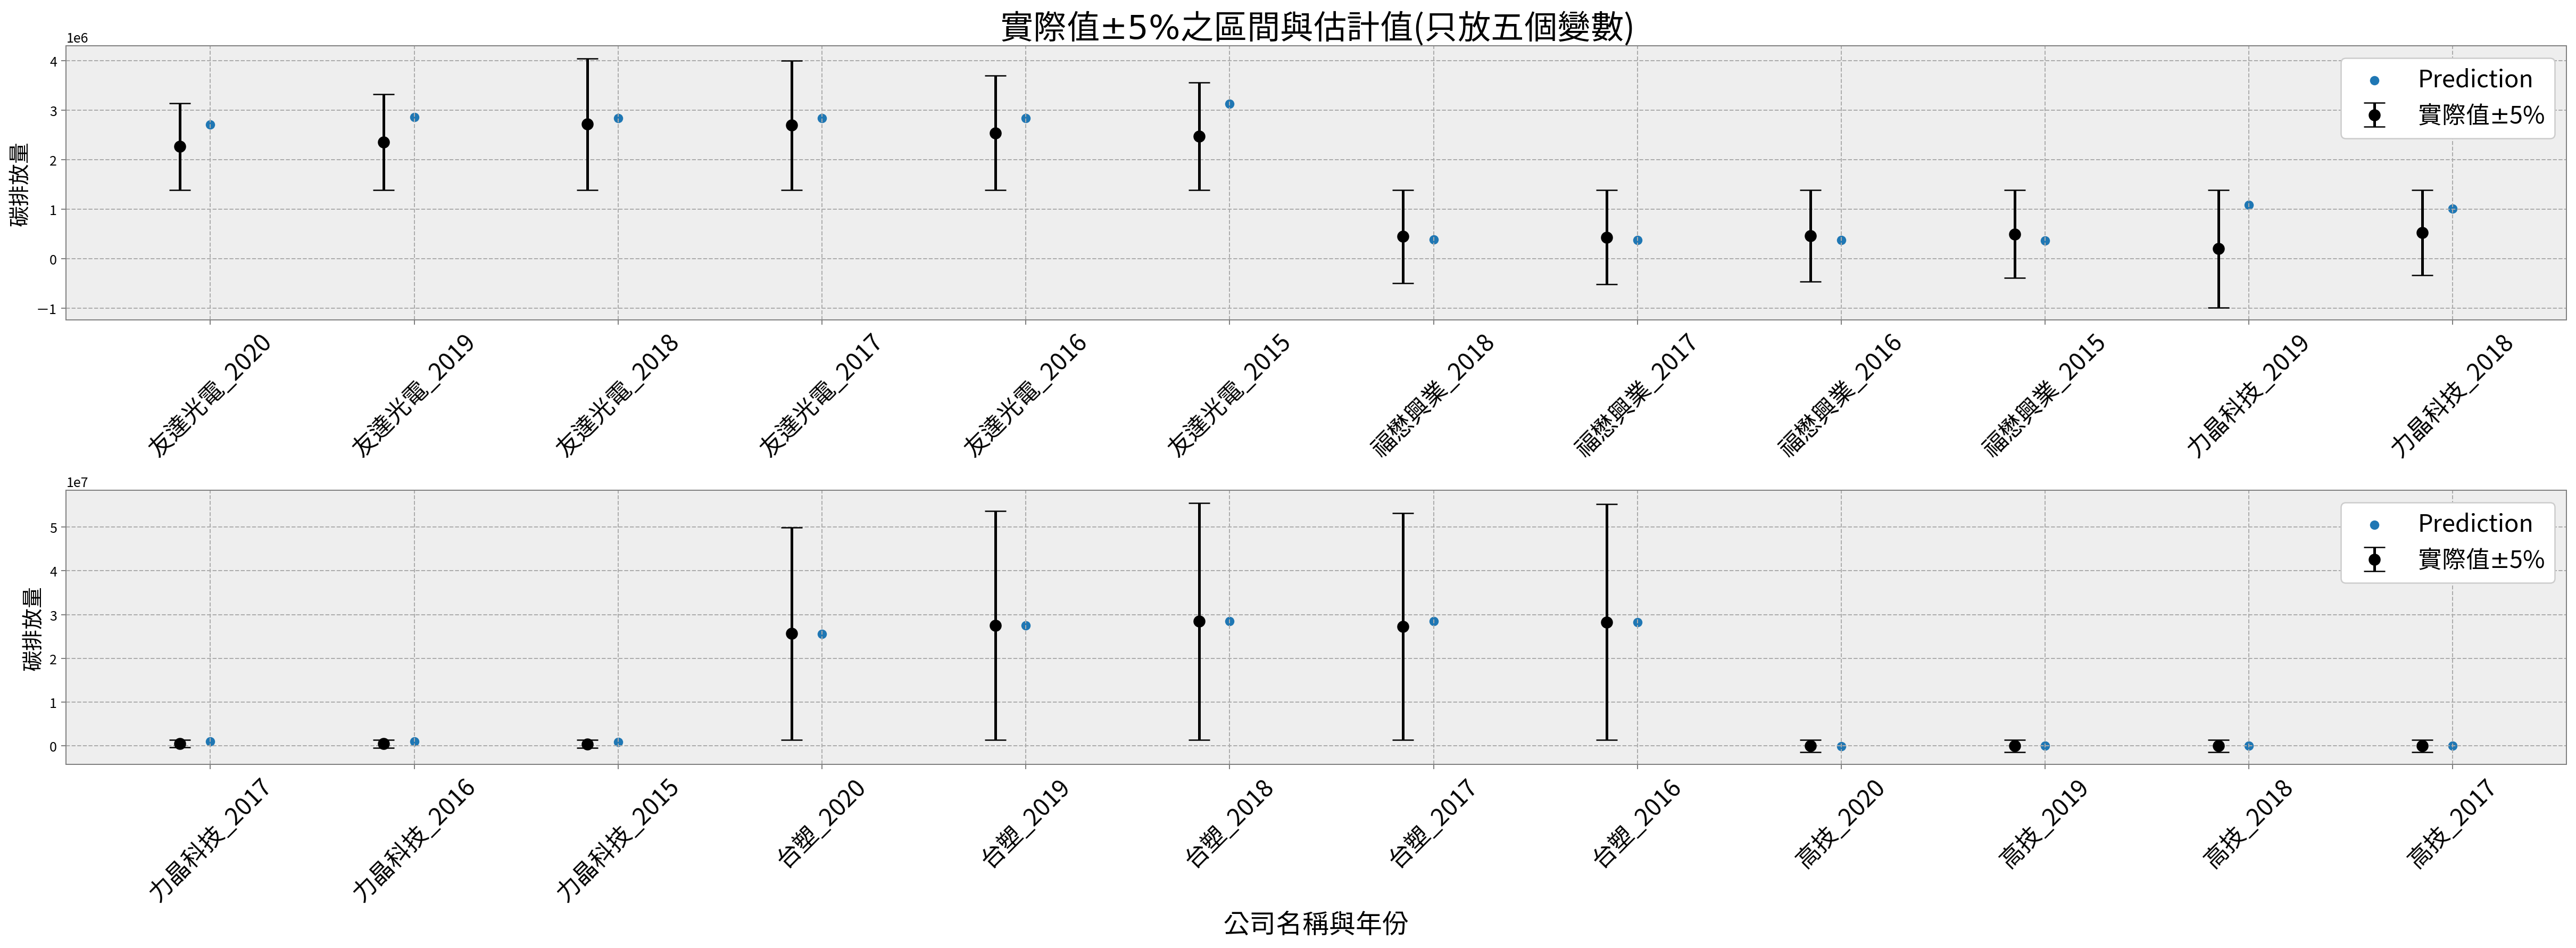

In [85]:
#生成xlabel的名稱，以公司名稱加上年份作為命名
#而因公司名稱與年份存在讀入的df中，因此由outsample dataframe取值

out_sample["公司_年"] = out_sample["公司名稱"] + "_" + out_sample["年"].astype(str)

##因為想把圖畫成兩列，因此需要先拆分資料成兩等份

#拆分set_xticklabels名稱
xlabel_front12 = out_sample["公司_年"].iloc[:12,]
xlabel_buttom12 = out_sample["公司_年"].iloc[12:,]
#拆分樣本外只用五個變數估計的預測值
full_fitted_5_features_fron12 = full_fitted_5_features[:12]
full_fitted_5_features_buttom12 = full_fitted_5_features[12:]
#拆分樣本外碳排放量
y_OutSample_front12 = y_OutSample[:12]
y_OutSample_buttom12 = y_OutSample[12:]

#設定樣本外碳排放的區間寬度，實際值正負5%的寬度，也就是alpha = 0.45, Z* = 0.1257
uncertainty = 0.1257*statistics.stdev(y_OutSample)

###------開始畫圖------------


#設定一張圖的數量，x = 12
x = np.array([i for i in range(12)])
#設定畫布
fig, axes = plt.subplots(2, 1, figsize=(27, 10), dpi = 180)

axes[0].errorbar(x - 0.15, y_OutSample_front12, yerr=[abs(uncertainty - y_OutSample_front12), abs(uncertainty - y_OutSample_front12)],
            fmt='o', label='實際值$\pm$5%', color='k', markersize=8, capsize=8, linewidth=2)

axes[0].scatter(x , full_fitted_5_features_fron12, label='Prediction')

styling(axes[0], x, xlabel_front12)
axes[0].set_ylabel('碳排放量', fontsize=16)
axes[0].set_title('實際值$\pm 5\%$之區間與估計值(只放五個變數)', fontsize=25)

#------下半張圖--------


axes[1].errorbar(x - 0.15, y_OutSample_buttom12, yerr=[abs(uncertainty - y_OutSample_buttom12), abs(uncertainty - y_OutSample_buttom12)],
            fmt='o', label='實際值$\pm$5%', color='k', markersize=8, capsize=8, linewidth=2)

axes[1].scatter(x , full_fitted_5_features_buttom12, label='Prediction')

styling(axes[1], x, xlabel_buttom12)
axes[1].set_ylabel('碳排放量', fontsize=16)
axes[1].set_xlabel('公司名稱與年份', fontsize=20)


fig.tight_layout()


# 預測值出現負值

## 先觀察負值出現的資料

In [80]:
#觀察樣本外估計值
full_fitted_5_features
#樣本外估計值無負數

array([ 2.71255475e+06,  2.85321275e+06,  2.83862225e+06,  2.83862225e+06,
        2.83763975e+06,  3.12254475e+06,  3.85966281e+05,  3.75180375e+05,
        3.77588562e+05,  3.64235250e+05,  1.07906662e+06,  1.00963325e+06,
        9.64129438e+05,  9.63849000e+05,  9.18819812e+05,  2.56078640e+07,
        2.75212360e+07,  2.84307460e+07,  2.84385640e+07,  2.82911540e+07,
       -2.48706426e+04,  1.49592451e+04,  6.26959375e+04,  6.28116914e+04],
      dtype=float32)

In [81]:
df_5feats_y_yfitted = ""
df_5feats_y_yfitted = X_5_features
df_5feats_y_yfitted["y"] = y
df_5feats_y_yfitted["y_fitted"] = full_fitted

company_info = data.columns[:4]
df_5feats_y_yfitted[company_info] = data.iloc[:, :4]

In [82]:
#df_5feats_y_yfitted

In [83]:
df_5feats_y_yfitted[(df_5feats_y_yfitted["y_fitted"] < 0)]

,生產量,存貨,不動產廠房及設備,應付帳款及票據,普通股股本,y,y_fitted,Unnamed:0,公司代號,公司名稱,產業別


***
***
#### 會出現估計值為負的可能有很多，我們的問題是：
1. 資料中還有碳排為零的資料，因此先去除。
2. 去除資料後還有兩筆估計值為負的資料
3. 發現可能是樹深不夠，我從6改為7；但通常而言是樹深過深才會出現負值。


***
***

## 再測試用所有資料且含onehot

In [48]:
#另存out sample df
X_OutSample_onehot = X_OutSample

#加入產業別文字變數以利下方生成one-hot
X_OutSample_onehot['產業別'] = out_sample['產業別']

#生成one-hot encoding
#由於樣本外產業只是總樣本的一部分所以要手動生成Oone-hot
for i in 產業別.unique().tolist():
    col_name = "產業別_" + i
    X_OutSample_onehot[col_name] = ""
    for n in range(len(X_OutSample_onehot["產業別"])):
        if X_OutSample_onehot["產業別"][n] == i:
            X_OutSample_onehot[col_name][n] = int(1)
        else:
            X_OutSample_onehot[col_name][n] = int(0)
        X_OutSample_onehot[col_name] = pd.to_numeric(X_OutSample_onehot[col_name])

In [49]:
#去除非數值變數才能建立模型
X_OutSample_onehot = X_OutSample_onehot.drop(columns = ["產業別"])

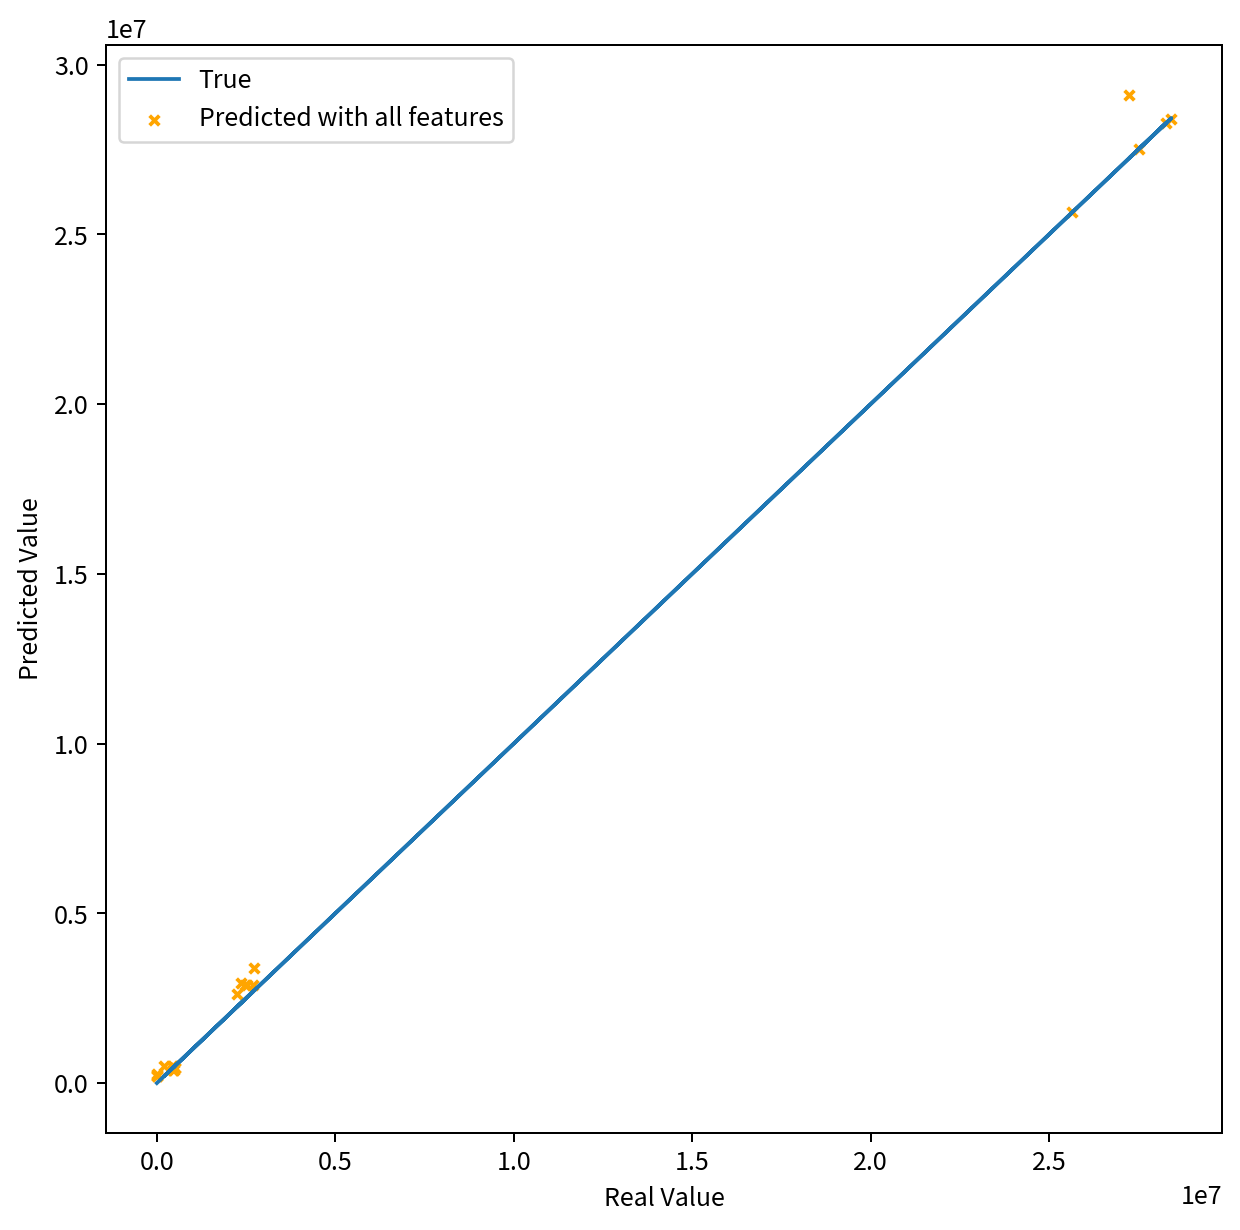

Out Sample with all features' R^2:  0.9981578698020915


In [50]:
full_fitted_FullandOnehot = xgb_regModel.predict(X_OutSample_onehot)

plt.figure(figsize=(8,8), dpi = 180)
plt.plot(y_OutSample, y_OutSample, label='True')
plt.scatter(y_OutSample, full_fitted_FullandOnehot, marker='x', color="orange",s = 15, label='Predicted with all features')
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()


#看測試集R^2
print("Out Sample with all features' R^2: ", xgb_regModel.score(X_OutSample_onehot, y_OutSample))


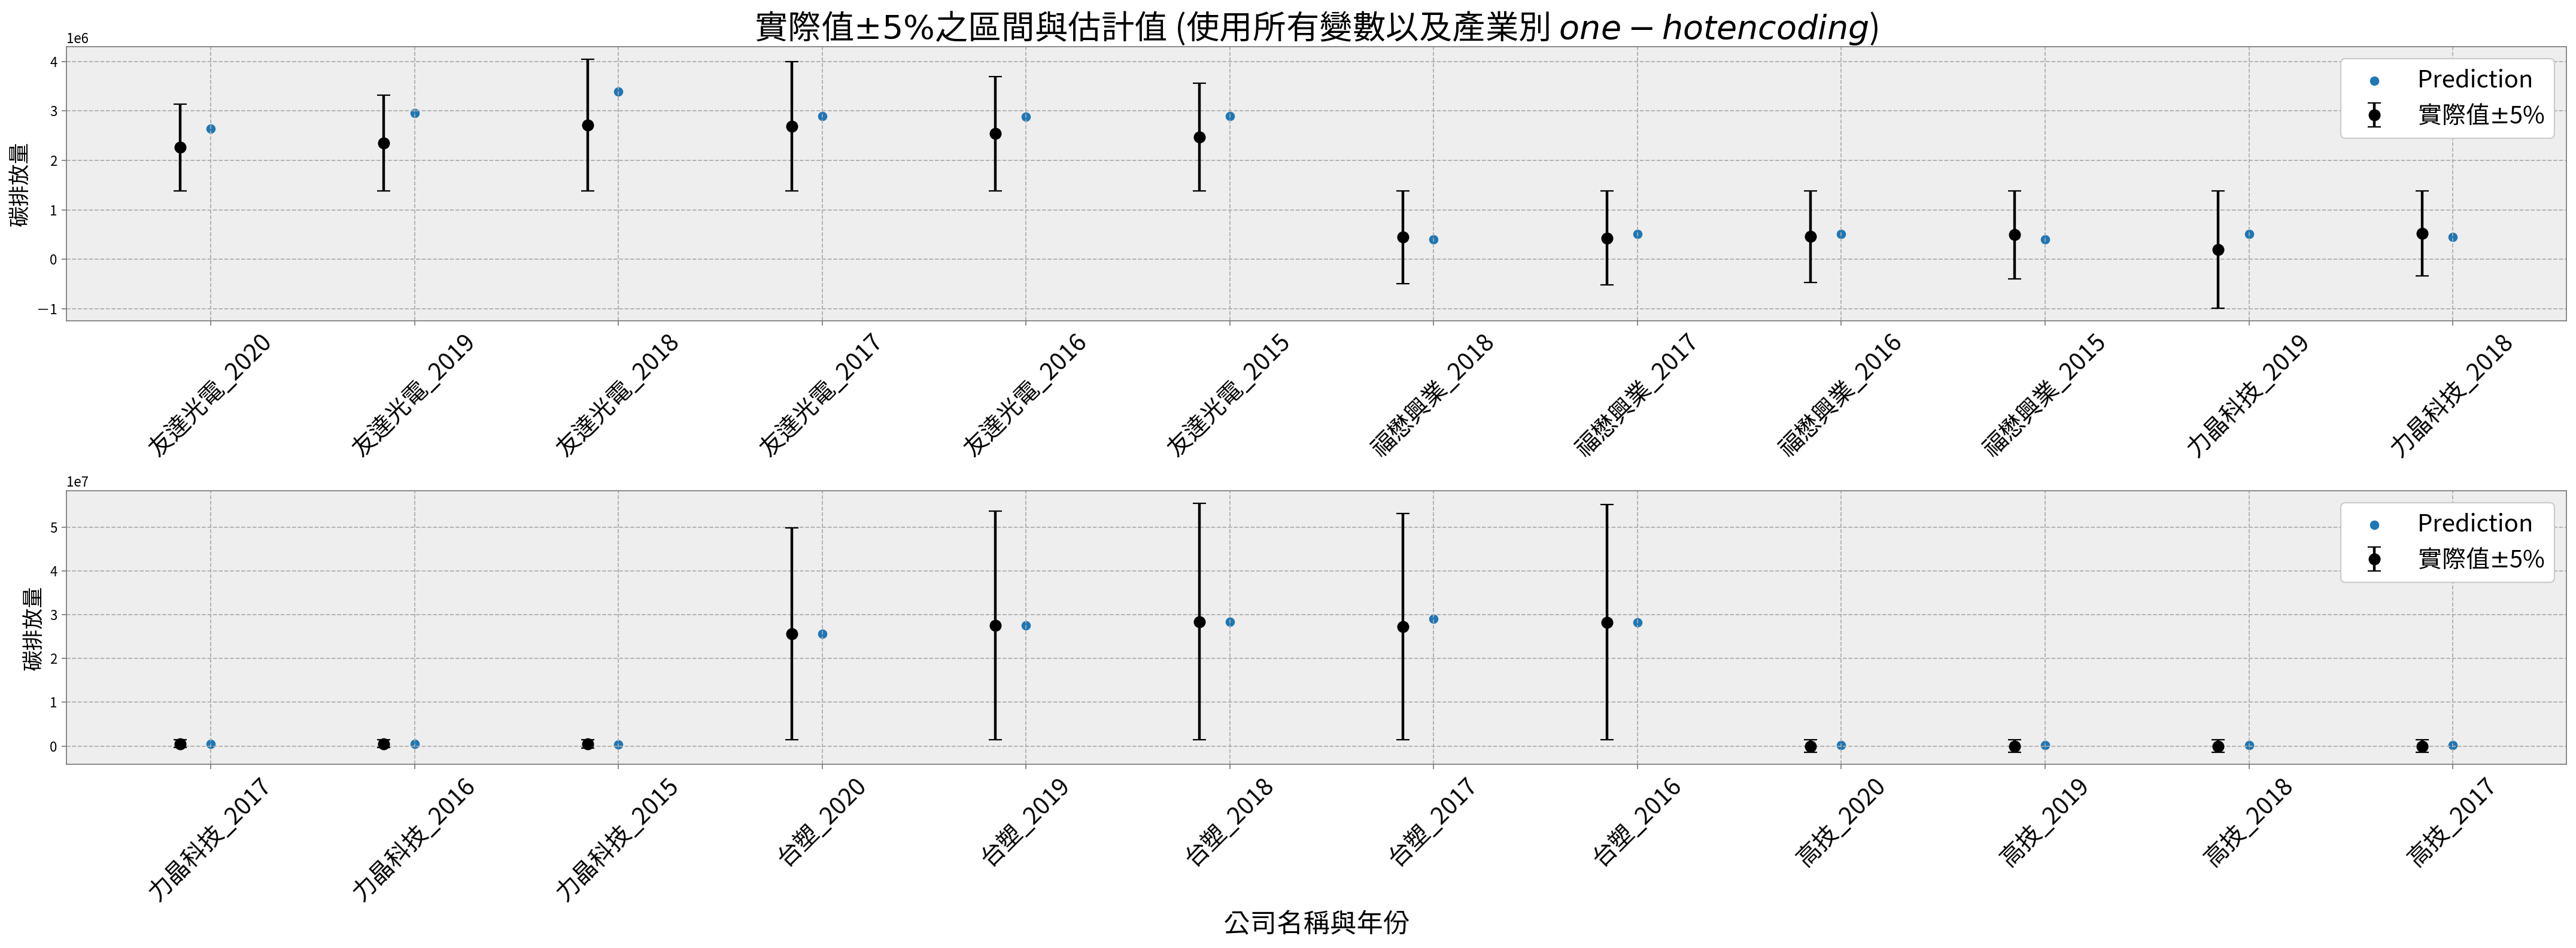

In [51]:
#生成xlabel的名稱，以公司名稱加上年份作為命名
#而因公司名稱與年份存在讀入的df中，因此由outsample dataframe取值

out_sample["公司_年"] = out_sample["公司名稱"] + "_" + out_sample["年"].astype(str)

##因為想把圖畫成兩列，因此需要先拆分資料成兩等份

#拆分xlabel名稱
xlabel_front12 = out_sample["公司_年"].iloc[:12,]
xlabel_buttom12 = out_sample["公司_年"].iloc[12:,]
#拆分樣本外只用五個變數估計的預測值
full_fitted_FullandOnehot_fron12 = full_fitted_FullandOnehot[:12]
full_fitted_FullandOnehot_buttom12 = full_fitted_FullandOnehot[12:]
#拆分樣本外碳排放量
y_OutSample_front12 = y_OutSample[:12]
y_OutSample_buttom12 = y_OutSample[12:]

#設定樣本外碳排放的區間寬度
uncertainty = 0.1257*statistics.stdev(y_OutSample)

###------開始畫圖------------


#設定一張圖的數量，x = 12
x = np.array([i for i in range(12)])
#設定畫布
fig, axes = plt.subplots(2, 1, figsize=(27, 10), dpi = 160)

axes[0].errorbar(x - 0.15, y_OutSample_front12, yerr=[abs(uncertainty - y_OutSample_front12), abs(uncertainty - y_OutSample_front12)],
            fmt='o', label='實際值$\pm$5%', color='k', markersize=8, capsize=5, linewidth=2)

axes[0].scatter(x , full_fitted_FullandOnehot_fron12, label='Prediction')

styling(axes[0], x, xlabel_front12)
axes[0].set_ylabel('碳排放量', fontsize=16)
axes[0].set_title('實際值$\pm 5\%$之區間與估計值 (使用所有變數以及產業別 $one-hot encoding$)', fontsize=25)

#------下半張圖--------


axes[1].errorbar(x - 0.15, y_OutSample_buttom12, yerr=[abs(uncertainty - y_OutSample_buttom12), abs(uncertainty - y_OutSample_buttom12)],
            fmt='o', label='實際值$\pm$5%', color='k', markersize=8, capsize=5, linewidth=2)

axes[1].scatter(x , full_fitted_FullandOnehot_buttom12, label='Prediction')

styling(axes[1], x, xlabel_buttom12)
axes[1].set_ylabel('碳排放量', fontsize=16)
axes[1].set_xlabel('公司名稱與年份', fontsize=20)


fig.tight_layout()


# 模型儲存

模型儲存
https://stackoverflow.com/questions/43691380/how-to-save-load-xgboost-model

>匯出後端資料

>能不能讓使用者選完產業後，後端先給定各產業平均值以及產業dummy?

In [52]:
#後端給定產業平均值的資料

csv_for_model_mean = X_mean_with_top5.drop(columns = top_tier_list).drop_duplicates()

In [53]:
X_median_for_pickle = X_mean_with_top5[top_tier_list]
X_median_for_pickle["產業別"] = 產業別
csv_for_model_median = X_median_for_pickle.groupby("產業別").median()

In [54]:
len(csv_for_model_median.columns)

5

In [55]:
path = r"C:\Users\hughw\Dropbox\2022 DIGI+ TALENT 工研院-智慧機械科技中心\data\\"
path.replace('\\','/')

csv_for_model_mean.to_csv(path.replace('\\','/')+"csv_for_model_mean.csv", encoding="utf_8_sig")
csv_for_model_median.to_csv(path.replace('\\','/')+"csv_for_model_median.csv", encoding="utf_8_sig")

>匯出模型

In [56]:
import pickle

#save model
pickle.dump(xgb_reg_5_features_Model, open("xgb_reg_5_features_Model.dat","wb"))

>匯入模型，進行測試

In [57]:
#load model
xgb_reg_5_features_Model_load = pickle.load(open("xgb_reg_5_features_Model.dat","rb"))

In [58]:
# 使用模型,對隨機抽取的數列randomlist轉成random_2Dnumpy再進行預測
import random
minimum = 10
maximum = 10000000000000
randomlist = []
for i in range(0, 5): #需輸入15個特徵
    n = random.randint(minimum, maximum)
    randomlist.append(n)

#key_in_data = []
#key_in_data.extend(randomlist)
#key_in_data.extend(np.zeros(24).tolist())
#key_in_data.extend(np.ones(1).tolist())


#random_2Dnumpy = np.array(key_in_data)[np.newaxis, :]
random_2Dnumpy = np.array(randomlist)[np.newaxis, :]

In [59]:
#輸入資料的時候要將資料轉為"two dimensional np array"，可見下方shape
random_2Dnumpy.shape

#注意：要把資料轉為float32

(1, 5)

In [60]:
#資料順序
X_5_features_test.columns

Index(['生產量', '存貨', '不動產廠房及設備', '應付帳款及票據', '普通股股本'], dtype='object')

In [61]:
xgb_reg_5_features_Model.predict(np.float32(random_2Dnumpy))

array([20011568.], dtype=float32)

In [62]:
xgb_reg_5_features_Model_load.predict(np.float32(random_2Dnumpy))

array([20011568.], dtype=float32)

In [63]:
xgb.__version__

'1.6.2'

# 遇到負的預測值從後端給最小值

In [64]:
df_for_min = data[["總碳排量", "產業別"]]

csv_for_NegativeValue = df_for_min.groupby("產業別").min()

path = r"C:\Users\hughw\Dropbox\2022 DIGI+ TALENT 工研院-智慧機械科技中心\data\\"
path.replace('\\','/')

csv_for_NegativeValue.to_csv(path.replace('\\','/')+"csv_for_NegativeValue.csv", encoding="utf_8_sig")